# Introduction

<b>Energy Disaggregation</b> is the process of extracting appliance consumption load curve from building consumption load curve. 

The process does not require installation of plug-level sensors for measuring each appliance's consumption. Rather it uses a set of statistical approaches and is non intrusive in nature, therefore also known as non-intrusive load monitoring or in short <b>NILM</b>. 

It is a significant data analytics technology to analyze the appliance level energy consumption in the residential and small commercial sector. This analysis further leads to energy use behaviour, demand forecasting, smart home frameworks, energy efficiency studies, occupancy detection etc.

<img src="figures/1_illustration.jpg">
<b><center>Figure 1: Energy Disaggregation Illustration</center></b>

# Working Principle

To implement energy disaggregation in real time, the following steps should be completed.

- Obtain the data of appliance level consumption and the energy meter consumption. Certain aspects are interesting to see in this respect. 
 - The data can be recorded for the use case or it can be obtained from open source.
 - Some open source datasets provide the energy meter load curve in the form of active power P and reactive power Q (or measured voltage V and current I at energy meter level). However most of the open source datasets only provides the active power P at energy meter level.
 - The resolution of the data is significant. A higher resolution data i.e. 1 minute sampling is more significant than lower resolution. i.e. 1 hour
 - Larger the data, better will be the capacity of the model to implement energy disaggregation.

- Choose and make trained models of the appliances using one or many statistical methods.
 - The signal processing techniques were earlier used to implement energy disaggregation. 
 - Later on, the factorial hidden markov model (FHMM) and decision trees were studied. 
 - Nowadays, research of neural networks has be done to implement energy disaggregation.
 - Certain time series features (e.g. lag, sliding window, one hot encoding, date_time information etc.) can be added to improve the efficiency of models.
 
- Validate the trained models and test on unseen data.

- Use the best trained model for each appliance to do energy disaggregation.

In this tutorial, we implement the energy disaggregation problem on an open source dataset. The characteristics of the dataset are given below.

# AMPDs dataset

The <b>AMPDs (the almanac of minutely power dataset)</b> was recorded in a house situated in the Greater Vancouver metropolitan area in British Columbia (Canada). The dataset contains two years of data sampled at 1 minute from 2012 to 2014. 

<img src="figures/2_makonin_home.jpg">
<b><center>Figure 2 : Electric Metering Bus Diagram (Source : http://makonin.com/doc/SciData_2016.pdf)</center></b>

The tutorial is programmed in <b>Python</b> language. The list of packages required to install is given in the text file <b>requirements.txt</b>. 

First we read the <b>AMPDs</b> dataset as a dataframe. 

In [1]:
# Importing required packages for pretreatment
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
%%time

# Data file directory and file name
file = "data/Electricity_AMPDs.csv"

# Reading csv file as a dataframe
df = pd.read_csv(file, header=0, index_col=0, parse_dates=True)

# Making the datatype of dataframe as "int32"
df = df.astype("int32")

# Displaying the first 5 rows
df.head()

Wall time: 3.31 s


,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,FRE,...,WOE,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE
UNIX_TS,,,,,,,,,,,,,,,,,,,,,
1333263600,918,43,2,873,0,352,0,0,41,106,...,0,58,0,30,0,0,4,0,37,138
1333263660,913,43,0,870,0,354,0,0,35,107,...,0,58,0,30,0,0,4,0,37,138
1333263720,872,43,2,827,0,354,0,0,41,107,...,0,8,0,30,0,0,4,0,37,138
1333263780,872,43,2,827,0,354,0,0,40,106,...,0,7,0,30,0,0,4,0,37,142
1333263840,772,41,2,729,0,352,0,0,40,106,...,0,8,0,31,0,0,4,0,37,45


# Pretreatment of dataset

The index of the dataframe is in <b>UNIX</b> format. To understand it better, we convert it in to <b>datetime</b> format.

In [3]:
# Header of the "datetime" column
time_column = 'time'

# Adding a new column of "time", which is based on the UNIX index and is in "datetime" format
df[time_column] = pd.to_datetime(df.index, unit='s', errors='coerce')

# Displaying the first 5 rows
df.head()

,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,FRE,...,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE,time
UNIX_TS,,,,,,,,,,,,,,,,,,,,,
1333263600,918,43,2,873,0,352,0,0,41,106,...,58,0,30,0,0,4,0,37,138,2012-04-01 07:00:00
1333263660,913,43,0,870,0,354,0,0,35,107,...,58,0,30,0,0,4,0,37,138,2012-04-01 07:01:00
1333263720,872,43,2,827,0,354,0,0,41,107,...,8,0,30,0,0,4,0,37,138,2012-04-01 07:02:00
1333263780,872,43,2,827,0,354,0,0,40,106,...,7,0,30,0,0,4,0,37,142,2012-04-01 07:03:00
1333263840,772,41,2,729,0,352,0,0,40,106,...,8,0,31,0,0,4,0,37,45,2012-04-01 07:04:00


In [4]:
# Displaying the last 5 rows
df.tail()

,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,FRE,...,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE,time
UNIX_TS,,,,,,,,,,,,,,,,,,,,,
1396335300,534,178,4,352,0,2,0,0,38,125,...,5,0,1,0,0,5,0,22,64,2014-04-01 06:55:00
1396335360,520,178,2,340,0,2,0,0,28,125,...,5,0,1,0,0,5,0,21,63,2014-04-01 06:56:00
1396335420,525,178,0,347,0,3,0,0,38,125,...,5,0,2,0,0,5,0,22,57,2014-04-01 06:57:00
1396335480,530,178,0,352,0,3,0,0,38,125,...,5,0,1,0,0,5,0,22,62,2014-04-01 06:58:00
1396335540,530,175,2,353,0,2,0,0,38,125,...,5,0,1,0,0,5,0,21,66,2014-04-01 06:59:00


If we look at the <b>time</b> column, we observe that the first timestamp starts at <b>07:00:00</b> . Similarly, if we look at the last timestamp, it is <b>06:59:00</b>. 

This is due to the fact that the function <b>to_datetime</b> considers the entry at the Universal Time Coordinated <b>UTC+0</b>, whereas the timezone of Vancouver, Canada is <b>UTC-7</b>. It is of our interest to remove the timezone information and reset the first timestamp to <b>midnight</b>, so that we should have standard days in our data.

First we need to add the <b>timezone</b> info in the timestamps.

In [5]:
# Sorting dataframe according to "time" column
df = df.sort_values(by=time_column)

# the timezone of UTC
tz_localize = 'UTC'

# Localizing the "time" at UTC i.e. GMT+0
df[time_column] = df[time_column].dt.tz_localize(tz_localize)

# Displaying the first 5 rows
df.head()

,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,FRE,...,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE,time
UNIX_TS,,,,,,,,,,,,,,,,,,,,,
1333263600,918,43,2,873,0,352,0,0,41,106,...,58,0,30,0,0,4,0,37,138,2012-04-01 07:00:00+00:00
1333263660,913,43,0,870,0,354,0,0,35,107,...,58,0,30,0,0,4,0,37,138,2012-04-01 07:01:00+00:00
1333263720,872,43,2,827,0,354,0,0,41,107,...,8,0,30,0,0,4,0,37,138,2012-04-01 07:02:00+00:00
1333263780,872,43,2,827,0,354,0,0,40,106,...,7,0,30,0,0,4,0,37,142,2012-04-01 07:03:00+00:00
1333263840,772,41,2,729,0,352,0,0,40,106,...,8,0,31,0,0,4,0,37,45,2012-04-01 07:04:00+00:00


We see that the timezone info <b>+00:00</b> is added to each timestamp in the <b>time</b> column, e.g the first timestamp is now "2012-04-01 07:00:00<b>+00:00</b>" instead of "2012-04-01 07:00:00". Next we convert the timestamps into <b>UTC-7</b> timezone.

In [6]:
# Timezone code for UTC-7
tz_convert = 'America/Vancouver'

df[time_column] = df[time_column].dt.tz_convert(tz_convert)

# Displaying the first 5 rows
df.head()

,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,FRE,...,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE,time
UNIX_TS,,,,,,,,,,,,,,,,,,,,,
1333263600,918,43,2,873,0,352,0,0,41,106,...,58,0,30,0,0,4,0,37,138,2012-04-01 00:00:00-07:00
1333263660,913,43,0,870,0,354,0,0,35,107,...,58,0,30,0,0,4,0,37,138,2012-04-01 00:01:00-07:00
1333263720,872,43,2,827,0,354,0,0,41,107,...,8,0,30,0,0,4,0,37,138,2012-04-01 00:02:00-07:00
1333263780,872,43,2,827,0,354,0,0,40,106,...,7,0,30,0,0,4,0,37,142,2012-04-01 00:03:00-07:00
1333263840,772,41,2,729,0,352,0,0,40,106,...,8,0,31,0,0,4,0,37,45,2012-04-01 00:04:00-07:00


We now see that the timezone info <b>-07:00</b> is added to each timestamp in the <b>time</b> column, e.g the first timestamp is now "2012-04-01 07:00:00<b>-07:00</b>" instead of "2012-04-01 07:00:00<b>+00:00</b>".

For further processing, we remove the timezone info from the timestamps.

In [7]:
# Making the tzinfo =None i.e. removing the timezone info
df[time_column] = df[time_column].dt.tz_localize(None)

# Displaying the first 5 rows
df.head()

,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,FRE,...,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE,time
UNIX_TS,,,,,,,,,,,,,,,,,,,,,
1333263600,918,43,2,873,0,352,0,0,41,106,...,58,0,30,0,0,4,0,37,138,2012-04-01 00:00:00
1333263660,913,43,0,870,0,354,0,0,35,107,...,58,0,30,0,0,4,0,37,138,2012-04-01 00:01:00
1333263720,872,43,2,827,0,354,0,0,41,107,...,8,0,30,0,0,4,0,37,138,2012-04-01 00:02:00
1333263780,872,43,2,827,0,354,0,0,40,106,...,7,0,30,0,0,4,0,37,142,2012-04-01 00:03:00
1333263840,772,41,2,729,0,352,0,0,40,106,...,8,0,31,0,0,4,0,37,45,2012-04-01 00:04:00


We see that the timezone info <b>-07:00</b> is removed from each timestamp. 

Now we will replace the <b>UNIX_TS</b> index with datetime index (given in <b>time</b> column).

In [8]:
# Setting the column as dataframe index
df = df.set_index([time_column])

# Displaying the first 5 rows
df.head()

,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,FRE,...,WOE,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE
time,,,,,,,,,,,,,,,,,,,,,
2012-04-01 00:00:00,918,43,2,873,0,352,0,0,41,106,...,0,58,0,30,0,0,4,0,37,138
2012-04-01 00:01:00,913,43,0,870,0,354,0,0,35,107,...,0,58,0,30,0,0,4,0,37,138
2012-04-01 00:02:00,872,43,2,827,0,354,0,0,41,107,...,0,8,0,30,0,0,4,0,37,138
2012-04-01 00:03:00,872,43,2,827,0,354,0,0,40,106,...,0,7,0,30,0,0,4,0,37,142
2012-04-01 00:04:00,772,41,2,729,0,352,0,0,40,106,...,0,8,0,31,0,0,4,0,37,45


Now that we have set a <b>datetime</b> index, we need to look at the columns of data. We observe that the column names are acronymed and are given in figure 2. So we change the acronymes by their actual title.

In [9]:
# The dictionary containing acronyms and the titles
column_headers = {'WHE': "whole_house", 'RSE':'rental_suite', 'GRE' : 'garage','MHE': 'main_house', 
                  'B1E': 'bedroom_1', 'BME': 'basement', 'CWE': 'clothes_washer','DWE': 'dish_washer', 
                  'EQE': 'equipment', 'FRE': 'furnace', 'HPE': 'heat_pump', 'OFE': 'home_office', 
                  'UTE': 'utility', 'WOE': 'wall_oven', 'B2E': 'bedroom_2', 'CDE': 'clothes_dryer', 
                  'DNE': 'dining_room', 'EBE': 'workbench', 'FGE': 'fridge', 'HTE': 'hot_water', 
                  'OUE': 'outside', 'TVE': 'tv_pvr', 'UNE': 'unmetered'}

# Renaming the columns
df = df.rename(columns=column_headers)

# Displaying the first 5 rows
df.head()

,whole_house,rental_suite,garage,main_house,bedroom_1,basement,clothes_washer,dish_washer,equipment,furnace,...,wall_oven,bedroom_2,clothes_dryer,dining_room,workbench,fridge,hot_water,outside,tv_pvr,unmetered
time,,,,,,,,,,,,,,,,,,,,,
2012-04-01 00:00:00,918,43,2,873,0,352,0,0,41,106,...,0,58,0,30,0,0,4,0,37,138
2012-04-01 00:01:00,913,43,0,870,0,354,0,0,35,107,...,0,58,0,30,0,0,4,0,37,138
2012-04-01 00:02:00,872,43,2,827,0,354,0,0,41,107,...,0,8,0,30,0,0,4,0,37,138
2012-04-01 00:03:00,872,43,2,827,0,354,0,0,40,106,...,0,7,0,30,0,0,4,0,37,142
2012-04-01 00:04:00,772,41,2,729,0,352,0,0,40,106,...,0,8,0,31,0,0,4,0,37,45


Since the <b>main_house</b> column gives us the site energy consumption measured by energy meter and their are certain appliances in the house with whom plug-level sensors are installed, therefore we will only select these columns to further refine our data.

In [10]:
# Appliances found in the house
appliances = ['main_house', 'clothes_washer', 'dish_washer', 'heat_pump', 
              'wall_oven', 'clothes_dryer', 'fridge', 'hot_water', 'tv_pvr']

# Only keeping the selected appliances and discarding other columns
df = df[appliances]

# Displaying the first 5 rows
df.head()

,main_house,clothes_washer,dish_washer,heat_pump,wall_oven,clothes_dryer,fridge,hot_water,tv_pvr
time,,,,,,,,,
2012-04-01 00:00:00,873,0,0,36,0,0,0,4,37
2012-04-01 00:01:00,870,0,0,37,0,0,0,4,37
2012-04-01 00:02:00,827,0,0,38,0,0,0,4,37
2012-04-01 00:03:00,827,0,0,37,0,0,0,4,37
2012-04-01 00:04:00,729,0,0,36,0,0,0,4,37


In [11]:
# Displaying the last 5 rows
df.tail()

,main_house,clothes_washer,dish_washer,heat_pump,wall_oven,clothes_dryer,fridge,hot_water,tv_pvr
time,,,,,,,,,
2014-03-31 23:55:00,352,0,0,38,0,0,0,5,22
2014-03-31 23:56:00,340,0,0,38,0,0,0,5,21
2014-03-31 23:57:00,347,0,0,39,0,0,0,5,22
2014-03-31 23:58:00,352,0,0,39,0,0,0,5,22
2014-03-31 23:59:00,353,0,0,38,0,0,0,5,21


Despite the fact that 2012 is a leap year, there is no leap day in the data. This is helpful in keeping the data coherent for both years. If we want to add the temporal features, we have to either keep 366 days in a year (non-standard year) or remove the data of leap data to make it data of 365 days (i.e a standard year).

Here we do not need to bother about that.

Now we should look at the information of the dataframe. 

In [12]:
# Data length in years as presented in the information of the dataset AMPDs
years = 2

# Number of Days in a standard year
days_per_year = 365

# Number of hours in a standard day
hours_per_day = 24

# Number of minutes in a standard hour
minutes_per_hour = 60

# Total number of entries expected in the dataset
total_expected_entries = years * days_per_year * hours_per_day * minutes_per_hour

print("Total entries expected : {}".format(total_expected_entries))

Total entries expected : 1051200


In [13]:
print("Total number of rows in dataframe : {}".format(df.shape[0]))
print("Total number of columns in dataframe : {}".format(df.shape[1]))

Total number of rows in dataframe : 1051200
Total number of columns in dataframe : 9


Since total number of rows in dataframe is <b>equal</b> to the total expected entries, therefore we can conclude that there is no missing entries in the data.

In [14]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1051200 entries, 2012-04-01 00:00:00 to 2014-03-31 23:59:00
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   main_house      1051200 non-null  int32
 1   clothes_washer  1051200 non-null  int32
 2   dish_washer     1051200 non-null  int32
 3   heat_pump       1051200 non-null  int32
 4   wall_oven       1051200 non-null  int32
 5   clothes_dryer   1051200 non-null  int32
 6   fridge          1051200 non-null  int32
 7   hot_water       1051200 non-null  int32
 8   tv_pvr          1051200 non-null  int32
dtypes: int32(9)
memory usage: 44.1 MB


Here we make two observations by calling <b>df.info()</b>:

- The index is a <b>datetime index</b> (with first and last index given).
- The entries in all the columns are <b>non-null</b>. therefore we do not need to interpolate the data.

Now we visually look the data in the form of line graph. Let us look at the first day.

In [15]:
%%time

# Format for converting "datetime" object into string
format_datetime = "%Y-%m-%d %H:%M:%S"

# First timestamp of first day in the dataset as datatype string
first_day_first_index = df.index[0].strftime(format_datetime)

# Last timestamp of first day in the dataset as datatype string
first_day_last_index = df.index[0].replace(hour=23, minute=59, second=0).strftime(format_datetime)

# Title of the plot
title_first_day = "First day energy load curves of AMPDs dataframe"

# Filtering data of first date in the dataframe
first_day = df.loc[first_day_first_index:first_day_last_index]

Wall time: 111 ms


Plotting with <b>matplotlib</b>

<IPython.core.display.Javascript object>


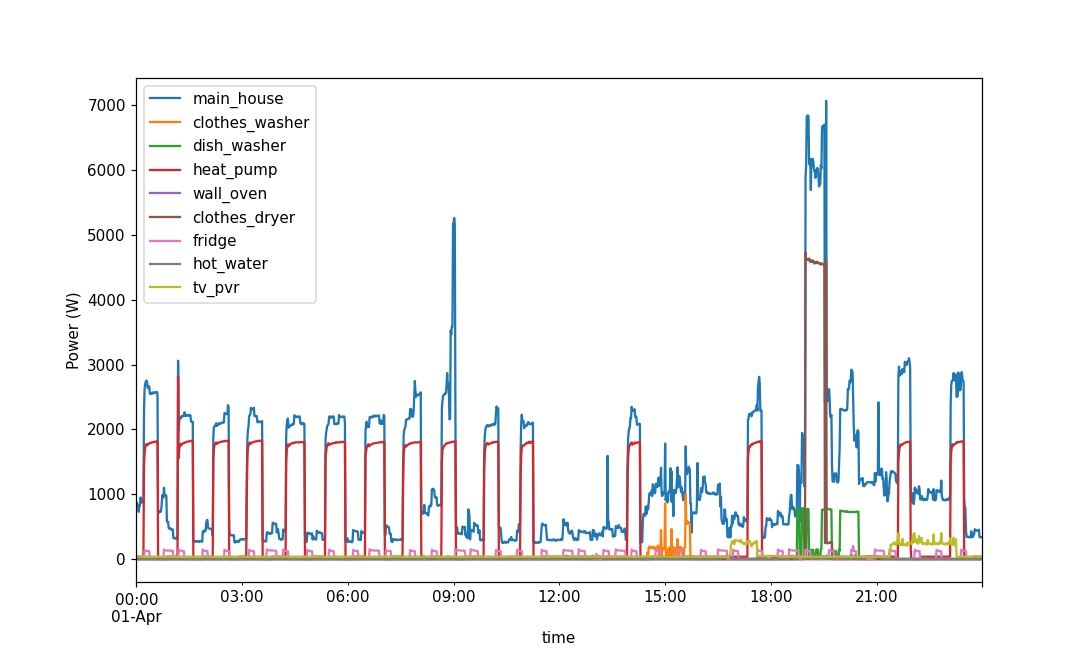

In [17]:
# Plotting first day
first_day.plot(figsize=(10, 6))

# Declaring y-label
plt.ylabel("Power (W)")

# Displaying the dataframe
plt.show()

# More to look at

- AMPDs dataset:  (http://ampds.org/)
- Stephen Makonin, Bradley Ellert, Ivan V. Bajic ́& Fred Popowich : Data Descriptor:Electricity, water,and natural gas consumption of aresidential house in Canada from 2012 to 2014 (http://makonin.com/doc/SciData_2016.pdf)
- Open Source Datasets: http://wiki.nilm.eu/datasets.html
